# Data processing for Olive groves

## Spatial projections of suitable area for all olive varieties in southern Spain

Data processing for Fig. 4 and SI2 of [this paper](https://www.sciencedirect.com/science/article/abs/pii/S0048969719361571).

### **Abstract**

World olive production is based on the cultivation of different varieties that respond differently to abiotic factors. Climate change may affect the area of land suitable for olive cultivation and change production levels, thus caus- ing serious damage to this economically-relevant and highly-productive olive grove agroecosystem. In Mediter- ranean regions such as Andalusia, one of the main areas of olive production, the effect of climate change seems threatening. Thus, our main aims are: (1) to examine the abiotic factors that characterise the current cultivated locations and predict the current and potential distribution of these locations; (2) to evaluate the effect of climate change (based on regional scenarios) on the future environmental suitability of each olive variety; and (3) to an- alyse the expected alteration in the annual olive production. We used the seven most-productive olive varieties in Andalusia and the wild olive species to develop Species Distribution Models (SDMs), coupled with soil prop- erties, geomorphology, water balance and (bio-)climatic predictors at a fine scale. We also derived future climate projections to assess the effect of climate change on the environmental suitability and productivity of each olive variety. 

**Olive varieties**

Among the long list of olive varieties which are currently cultivated in Andalusia, we selected those catalogued as “principal” and that are the most used in Andalusian olive groves in rain-fed regimes (Rubio de Casas et al., 2002), namely: Hojiblanca (Hj), Lechín de Sevilla (Lch), Manzanilla de Sevilla (Mnz), Nevadillo negro (Nvd), Picudo (Pcd), Picual (Pcl) and Verdial de Huévar (Vrd). We also used the wild olive tree (Acebuche, Oe), closely related to the domesticated olive tree. Two varieties stand out for their importance in terms of area in An- dalusia: Picual, which represents about 60% of the olive groves, and Hojiblanca, with around 20%.


| Target                              | Code   | Main features                                                | Area (km2)        |
|-------------------------------------|--------|--------------------------------------------------------------|-------------------|
|Acebuche                             |Oe      |Wild species of reference                                     | 2161              |
|Hojiblanca                           |Hj      |Very-frequent olive-tree variety cultivated in plant nurseries| 7868              |
|Lechín de Sevilla                    |Lch     |Frequent olive-tree variety in plant nurseries                | 3221              |
|Manzanilla de Sevilla                |Mnz     |Frequent olive-tree variety in plant nurseries                | 2654              |
|Nevadillo negro                      |Nvd     |Traditional olive-tree variety                                | 1114              |
|Picudo                               |Pcd     |Traditional olive-tree variety                                | 2459              |
|Picual                               |Pcl     |Very-frequent olive-tree variety cultivated in plant nurseries| 18,677            |         
|Verdial de Huévar                    |Vrd     |Traditional olive-tree variety                                | 865               |



**Regional climate projections for Andalusia**

To understand the future distribution and assess the environmental suitability of each olive variety, we used the Local Scenarios of Climate Change of Andalusia (ELCCA) (URL: [http://www.juntadeandalucia.es/ medioambiente/site/rediam](https://www.juntadeandalucia.es/medioambiente/portal/datos-ambientales?categoryVal=)). These regional climate change scenarios were specifically developed for the Andalusia region to represent the changes expected in the climate in the coming decades, according to studies carried out on a planetary scale. The scenarios were produced from the Third Generation Coupled Global Climate Model (MCGs; CNCM3), for a balance across all sources (A1b; IV IPCC Report), for three periods: `2011–2040` (“Proj-2040”), `2041–2070` (“Proj-2070”) and `2071–2100` (“Proj-2100”). 
The baseline (current) climatic data used to run the models comprised the average values for the interval `1961–2000`. From these simulations, (bio-)climatic variables (such as monthly precipitation and temperature) were derived. We then calcu- lated aggregation statistics (the mean as well as the 5%, 50% and 95% quantiles) for all the climatic variables, to assess projected changes in the study region.


## Climate change projections for olive yields in the Mediterranean Basin

Data processing for Fig. 2-4 [this paper](https://rmets.onlinelibrary.wiley.com/doi/abs/10.1002/joc.6237).

### **Abstract**

The olive tree is one of the most important crops in the Mediterranean basin. Given
the strong climatic influence on olive trees, it becomes imperative to assess climate
change impacts on this crop. Herein, these impacts were innovatively assessed, based
on an ensemble of state-of-the-art climate models, future scenarios and dynamic crop
models. The recent-past (`1989–2005`) and future (`2041–2070`, RCP4.5 and RCP8.5)
olive growing season length (GSL), yield, growing season temperature (GST) and pre-
cipitation (GSP), potential (ETP) and actual (ETA) evapotranspiration, water demand
(WD) and water productivity (WP) were assessed over Southern Europe

# Setup
## Library import
We import all the required Python libraries

In [50]:
import os
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from shapely.geometry import box
from tqdm import tqdm
from osgeo import gdal
import gdal2tiles
import ipyleaflet as ipyl
from dotenv import load_dotenv
import glob
from google.cloud import storage
from google.oauth2 import service_account
from typing import List

# Data import
## Spatial projections of suitable area for all olive varieties in southern Spain
### Vector data
**Read data**

In [ ]:
df_all = pd.read_csv('../../datasets/raw/crops/olivar/Arenas_Castro/EnsSuitability_AllVarieties_Q95_woutNA.csv')
df_all.head()

**Create grid**

In [ ]:
gdf_all = gpd.GeoDataFrame(df_all, geometry=gpd.points_from_xy(df_all.x, df_all.y))
gdf_all = gdf_all.set_crs("EPSG:4326")

In [ ]:
# total area for the grid
xmin, ymin, xmax, ymax= gdf_all.total_bounds
# how many cells across and down
n_cells=gdf_all['x'].nunique()
cell_size = (xmax-xmin)/n_cells
# projection of the grid
crs = "EPSG:4326"
grid_cells = []
for x0 in np.arange(xmin, xmax+cell_size, cell_size ):
    for y0 in np.arange(ymin, ymax+cell_size, cell_size):
        # bounds
        x1 = x0-cell_size
        y1 = y0+cell_size
        grid_cells.append(box(x0+cell_size*0.5, y0-cell_size*0.5, x1+cell_size*0.5, y1-cell_size*0.5)  )
cell = gpd.GeoDataFrame(grid_cells, columns=['geometry'], crs=crs)

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
#cell.plot(ax=ax, facecolor="none", edgecolor='grey')
gdf_all.plot(ax=ax, column='current.Q95', markersize=8)
#ax.set_ylim([37.5,38]);
#ax.set_xlim([-5,-4.5]);

**Intersect points with grid**

In [ ]:
polygons = []
sindex = cell.sindex
# Iterate over the geometries
for n, geometry in enumerate(tqdm(gdf_all.geometry)):

    # Find approximate matches with r-tree
    possible_matches_index = list(sindex.intersection(geometry.bounds))
    possible_matches = cell.iloc[possible_matches_index]
    # Find precise matches with r-tree
    polygons.append(possible_matches[possible_matches.intersects(geometry)]['geometry'].iloc[0])

### Raster data
**Read data**

In [7]:
years_file = {'1961–2000': 'EnsSuitability_AllVarieties_Q95_Present.tif',
             '2011–2040': 'EnsSuitability_AllVarieties_Q95_Proj2040.tif',
             '2041–2070': 'EnsSuitability_AllVarieties_Q95_Proj2070.tif',
             '2071–2100': 'EnsSuitability_AllVarieties_Q95_Proj2100.tif'}

for i, year in enumerate(years_file.keys()):

    # Read tiff
    xda = xr.open_rasterio(f'../../datasets/raw/crops/olivar/Arenas_Castro/{years_file[year]}').squeeze().drop("band")
    
    # replace all values equal to -3.4e+38 with np.nan
    xda = xda.where(xda != list(xda.attrs['nodatavals'])[0]) 
        
    # add time and depth coordinates
    xda = xda.assign_coords({"time": year}).expand_dims(['time'])
    
    # convert to Dataset and concatenate by depth
    if year == '1961–2000':
        xds = xr.Dataset({'EnsSuitability_AllVarieties_Q95': xda}, attrs=xda.attrs)
    else:
        xds_time = xr.Dataset({'EnsSuitability_AllVarieties_Q95': xda}, attrs=xda.attrs)

        xds = xr.concat([xds, xds_time], dim='time')

/tmp/ipykernel_145/608946608.py:9: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  xda = xr.open_rasterio(f'../../datasets/raw/crops/olivar/Arenas_Castro/{years_file[year]}').squeeze().drop("band")
/tmp/ipykernel_145/608946608.py:9: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  xda = xr.open_rasterio(f'../../datasets/raw/crops/olivar/Arenas_Castro/{years_file[year]}').squeeze().drop("band")
/tmp/ipykernel_145/608946608.py:9: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  xda = xr.open_rasterio(f'../../datasets/raw/crops/olivar/Arenas_Castro/{years_fi

In [3]:
xds

<xarray.Dataset>
Dimensions:                          (y: 274, x: 590, time: 4)
Coordinates:
  * y                                (y) float64 38.73 38.72 ... 36.01 36.0
  * x                                (x) float64 -7.517 -7.507 ... -1.637 -1.627
  * time                             (time) <U9 '1961–2000' ... '2071–2100'
Data variables:
    EnsSuitability_AllVarieties_Q95  (time, y, x) float32 nan nan ... nan nan
Attributes:
    transform:      (0.01, 0.0, -7.522276026, 0.0, -0.009999999999999981, 38....
    crs:            +init=epsg:4326
    res:            (0.01, 0.009999999999999981)
    is_tiled:       0
    nodatavals:     (-3.3999999521443642e+38,)
    scales:         (1.0,)
    offsets:        (0.0,)
    AREA_OR_POINT:  Area

**Display data**

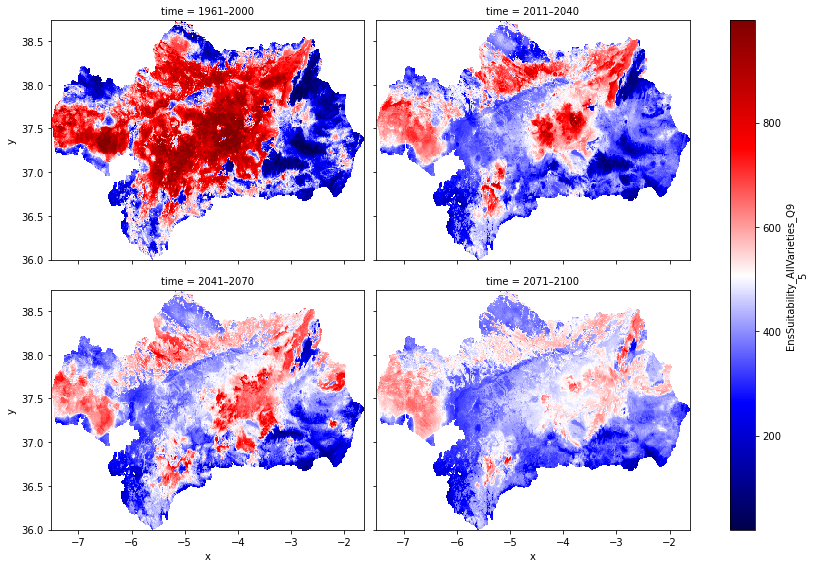

In [4]:
xds['EnsSuitability_AllVarieties_Q95'].plot(x="x", y="y", col="time", col_wrap=2, cmap='seismic', figsize=(12,8))

**Display data on map with `xarray-leaflet`**

In [5]:
import xarray_leaflet
import rioxarray
import ipyleaflet as ipyl

m = ipyl.Map()
l = xds['EnsSuitability_AllVarieties_Q95'].isel(time=3).leaflet.plot(m)
m.add_layer(l)
m

Url()

Map(center=[0.0, 0.0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

#### **Generate tiles with [`gdal2tiles`](https://gdal.org/programs/gdal2tiles.html)**

**Transform Tiff to `uint8`**

In [6]:
input_file = '../../datasets/raw/crops/olivar/EnsSuitability_AllVarieties_Q95_Present.tif'
output_file = '../../datasets/raw/crops/olivar/EnsSuitability_AllVarieties_Q95_Present_Byte.tif'

In [7]:
#If dataset dtype isn't uint8 will need to transform
#ensure there's as many -b as bands in the image (max 3)
!gdal_translate \
    -ot Byte \
    -scale \
    -co tiled=yes \
    -co compress=deflate \
    -b 1\
    {input_file} {output_file}

#in the second to last row, add -b1 -b2 -b3 if 3-band raster

Input file size is 590, 274
Warning 1: for band 1, nodata value has been clamped to 0, the original value being out of range.
0...10...20...30...40...50...60...70...80...90...100 - done.


**Create tiles**

In [8]:
def create_tiles(source_path, destination_path):
    """
    Method to generate tiles at different zoom levels using gdal2tiles library.
    Args:
    source_path : path for the source file which needs to be tiled
    destination_path : path for the output directory where the tiles will be generated
    """
    options = {'zoom': '5',
               'nb_processes': 48,
               'tile_size': 256,
               'srs':'EPSG:4326'}
    gdal2tiles.generate_tiles(source_path, destination_path,
     **options)

In [9]:
source_path = '../../datasets/raw/crops/olivar/EnsSuitability_AllVarieties_Q95_Present_Byte.tif'
destination_path = '../../datasets/processed/RasterTiles/olivar/1961_2000/'

In [10]:
create_tiles(source_path, destination_path)

Generating Base Tiles:
0...10...20...30...40...50...60...70...80...90...100


[`--xyz`](https://gdal.org/programs/gdal2tiles.html#cmdoption-gdal2tiles-xyz) option is required to generate XYZ tiles ([OSM Slippy Map standard](https://wiki.openstreetmap.org/wiki/Slippy_map_tilenames)) instead of [TMS](https://en.wikipedia.org/wiki/Tile_Map_Service)

In [11]:
!gdal2tiles.py --xyz --zoom=0-8 --processes=48 --tilesize=256 --s_srs='EPSG:4326' {source_path} {destination_path}

Generating Base Tiles:
0...10...20...30...40...50...60...70...80...90...100
Generating Overview Tiles:
0...10...20...30...40...50...60...70...80...90...100


In [12]:
!pwd

/home/jovyan/work/notebooks/Lab


Change tile permissions

In [13]:
!find ../../datasets/processed/RasterTiles/olivar/1961_2000/ -type f -exec chmod 777 {} \;

**Display tiles**

In [5]:
center = (38, -5)
m = ipyl.Map(center=(center), zoom=6)

m.add_layer(ipyl.LocalTileLayer(path='/tree/work/datasets/processed/RasterTiles/olivar/1961_2000/{z}/{x}/{y}.png'))

control = ipyl.LayersControl(position='topright')
m.add_control(control)
m.add_control(ipyl.FullScreenControl())
m

Map(center=[38, -5], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_tex…

#### **Upload files to GCS**

In [20]:
def upload_local_directory_to_gcs(bucket_name, local_path, destination_blob_path):
    """Uploads a directory to the bucket."""
    
    credentials_dict = {
          "type": "service_account",
          "project_id": os.getenv("PROJECT_ID"),
         "private_key_id": os.getenv("PRIVATE_KEY_ID"),
          "private_key":os.getenv("PRIVATE_KEY"),
         "client_email": os.getenv("CLIENT_EMAIL"),
          "token_uri":os.getenv("TOKEN_URI"),   
    } 
    

    credentials = service_account.Credentials.from_service_account_info(credentials_dict)
    storage_client = storage.Client(project='project_id', credentials=credentials)
    
    bucket = storage_client.bucket(bucket_name)
    rel_paths = glob.glob(local_path + '/**', recursive=True)

    for local_file in rel_paths:
        remote_path = f'{destination_blob_path}{"/".join(local_file.split(os.sep)[len(local_path.split(os.sep))-1:])}'
        if os.path.isfile(local_file):
            blob = bucket.blob(remote_path)
            print(
                "File {} uploaded to {}.".format(
                    local_file, remote_path
                )
            )
            blob.upload_from_filename(local_file)

In [22]:
load_dotenv()


bucket_name = 'ecf-agricultural-climate-impact'
local_path = '../../datasets/processed/RasterTiles/olivar/1961_2000/'
destination_blob_path = 'RasterTiles/olivar/1961_2000/'

upload_local_directory_to_gcs(bucket_name, local_path, destination_blob_path)

File ../../datasets/processed/RasterTiles/olivar/1961_2000/googlemaps.html uploaded to RasterTiles/olivar/1961_2000/googlemaps.html.
File ../../datasets/processed/RasterTiles/olivar/1961_2000/openlayers.html uploaded to RasterTiles/olivar/1961_2000/openlayers.html.
File ../../datasets/processed/RasterTiles/olivar/1961_2000/tilemapresource.xml uploaded to RasterTiles/olivar/1961_2000/tilemapresource.xml.
File ../../datasets/processed/RasterTiles/olivar/1961_2000/2/1/1.png uploaded to RasterTiles/olivar/1961_2000/2/1/1.png.
File ../../datasets/processed/RasterTiles/olivar/1961_2000/4/7/6.png uploaded to RasterTiles/olivar/1961_2000/4/7/6.png.
File ../../datasets/processed/RasterTiles/olivar/1961_2000/3/3/3.png uploaded to RasterTiles/olivar/1961_2000/3/3/3.png.
File ../../datasets/processed/RasterTiles/olivar/1961_2000/0/0/0.png uploaded to RasterTiles/olivar/1961_2000/0/0/0.png.
File ../../datasets/processed/RasterTiles/olivar/1961_2000/6/31/24.png uploaded to RasterTiles/olivar/1961_20

**Make bucket  publicly readable**

In [ ]:
from typing import List

from google.cloud import storage

def set_bucket_public_iam(
    bucket_name: str = "your-bucket-name",
    members: List[str] = ["allUsers"],
):
    """Set a public IAM Policy to bucket"""
    # bucket_name = "your-bucket-name"

    credentials_dict = {
          "type": "service_account",
          "project_id": os.getenv("PROJECT_ID"),
         "private_key_id": os.getenv("PRIVATE_KEY_ID"),
          "private_key":os.getenv("PRIVATE_KEY"),
         "client_email": os.getenv("CLIENT_EMAIL"),
          "token_uri":os.getenv("TOKEN_URI"),   
    } 
    

    credentials = service_account.Credentials.from_service_account_info(credentials_dict)
    storage_client = storage.Client(project='project_id', credentials=credentials)
    bucket = storage_client.bucket(bucket_name)

    policy = bucket.get_iam_policy(requested_policy_version=3)
    policy.bindings.append(
        {"role": "roles/storage.objectViewer", "members": members}
    )

    bucket.set_iam_policy(policy)

    print("Bucket {} is now publicly readable".format(bucket.name))

In [ ]:
set_bucket_public_iam('ecf-agricultural-climate-impact', ["allUsers"])

**Display tiles**

In [6]:
center = (38, -5)
m = ipyl.Map(center=(center), zoom=6)

m.add_layer(ipyl.TileLayer(
    url='https://storage.googleapis.com/ecf-agricultural-climate-impact/RasterTiles/olivar/1961_2000/{z}/{x}/{y}.png',
    layers='olivar',
    format='image/png',
    name='olivar',
    opacity=1
))

control = ipyl.LayersControl(position='topright')
m.add_control(control)
m.add_control(ipyl.FullScreenControl())
m

Map(center=[38, -5], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_tex…

***
## Climate change projections for olive yields in the Mediterranean Basin
### Raster data
**Read data**

In [75]:
years_file = {'1989–2005': 'present.nc',
             '2041–2070': 'future_rcp85.nc'}

for i, year in enumerate(years_file.keys()):

    # Read tiff
    xds_tmp = xr.open_dataset(f'../../datasets/raw/crops/olivar/Fraga/{years_file[year]}', decode_coords="all")
        
    
    # convert to Dataset and concatenate by time
    if year == '1989–2005':
        xds = xds_tmp
    else:
        xds = xr.concat([xds, xds_tmp], dim='time')

In [76]:
xds

<xarray.Dataset>
Dimensions:  (lon: 376, lat: 200, time: 2)
Coordinates:
  * lon      (lon) float64 -11.94 -11.81 -11.69 -11.56 ... 34.69 34.81 34.94
  * lat      (lat) float64 35.06 35.19 35.31 35.44 ... 59.56 59.69 59.81 59.94
  * time     (time) float64 17.0 30.0
Data variables:
    yield    (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
Attributes:
    CDI:          Climate Data Interface version 1.5.0 (http://code.zmaw.de/p...
    Conventions:  CF-1.0
    history:      Wed Nov 24 15:03:28 2021: cdo selvar,yield eval_mean.nc pre...
    CDO:          Climate Data Operators version 1.5.1rc3 (http://code.zmaw.d...

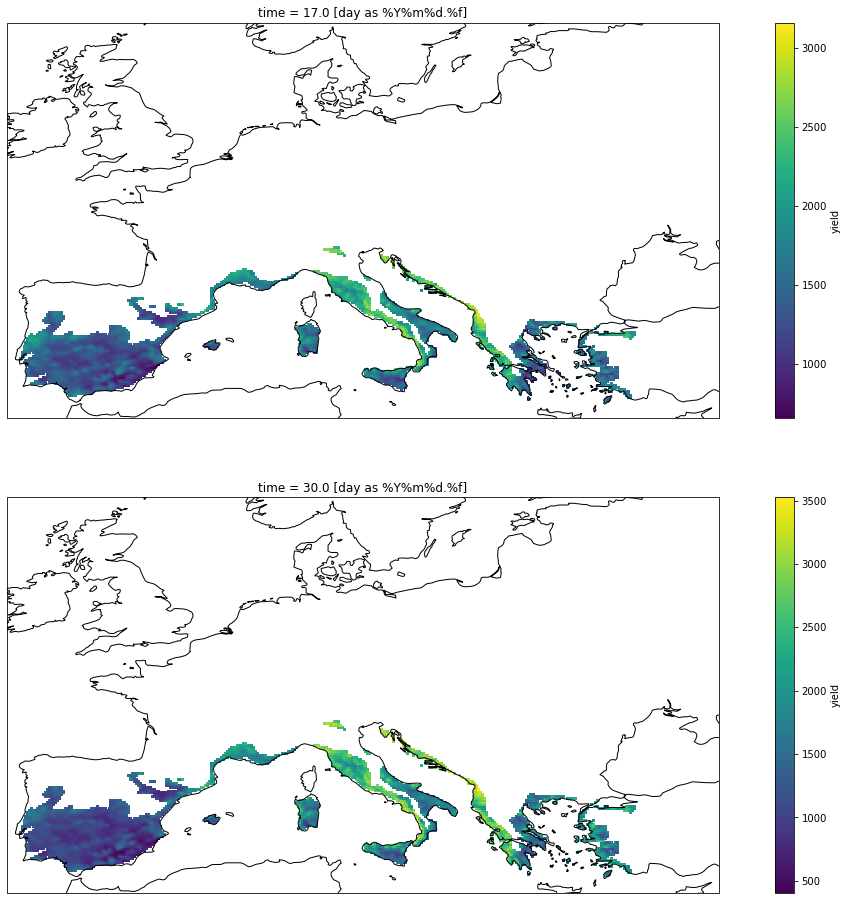

In [74]:
fig = plt.figure(figsize=(20,16))

ax1 = fig.add_subplot(211, projection=ccrs.PlateCarree())
ax2 = fig.add_subplot(212, projection=ccrs.PlateCarree())

ax1.set_global()
xds['yield'].isel(time=0).plot.pcolormesh(ax=ax1, transform=ccrs.PlateCarree(), x='lon', y='lat', add_colorbar=True)
ax1.coastlines()
ax1.set_ylim([35,60]);
ax1.set_xlim([-10,35]);

ax2.set_global()
xds['yield'].isel(time=1).plot.pcolormesh(ax=ax2, transform=ccrs.PlateCarree(), x='lon', y='lat', add_colorbar=True)
ax2.coastlines()
ax2.set_ylim([35,60]);
ax2.set_xlim([-10,35]);

**Clip array with spain**

In [77]:
## Spain
spain = gpd.read_file('../../datasets/processed/spain.geojson', driver='GeoJSON')

In [168]:
for ns, scenario in enumerate(['rcp45', 'rcp85']):

    years_file = {'1989–2005': 'present.nc',
                  '2041–2070': f'future_{scenario}.nc'}
    
    for i, year in enumerate(years_file.keys()):
    
        # Read tiff
        xds_tmp = xr.open_dataset(f'../../datasets/raw/crops/olivar/Fraga/{years_file[year]}', decode_coords="all")
        
        # Clip
        xds_tmp.rio.write_crs("EPSG:4326", inplace=True)    
        xds_tmp = xds_tmp.rio.clip(spain.geometry.values, spain.crs)
        
        xds_tmp = xds_tmp.assign_coords({'time': [year]})
        xds_tmp = xds_tmp.assign_coords({"scenario": scenario})
        
        # convert to Dataset and concatenate by time
        if year == '1989–2005':
            xds_clipped = xds_tmp
        else:
            xds_clipped = xr.concat([xds_clipped, xds_tmp], dim='time')
        
    if ns == 0:
        ds_clipped = xds_clipped.copy()
    else:
        ds_clipped = xr.concat([ds_clipped, xds_clipped.copy()], dim='scenario')
        
ds_clipped = ds_clipped.drop_vars('spatial_ref')

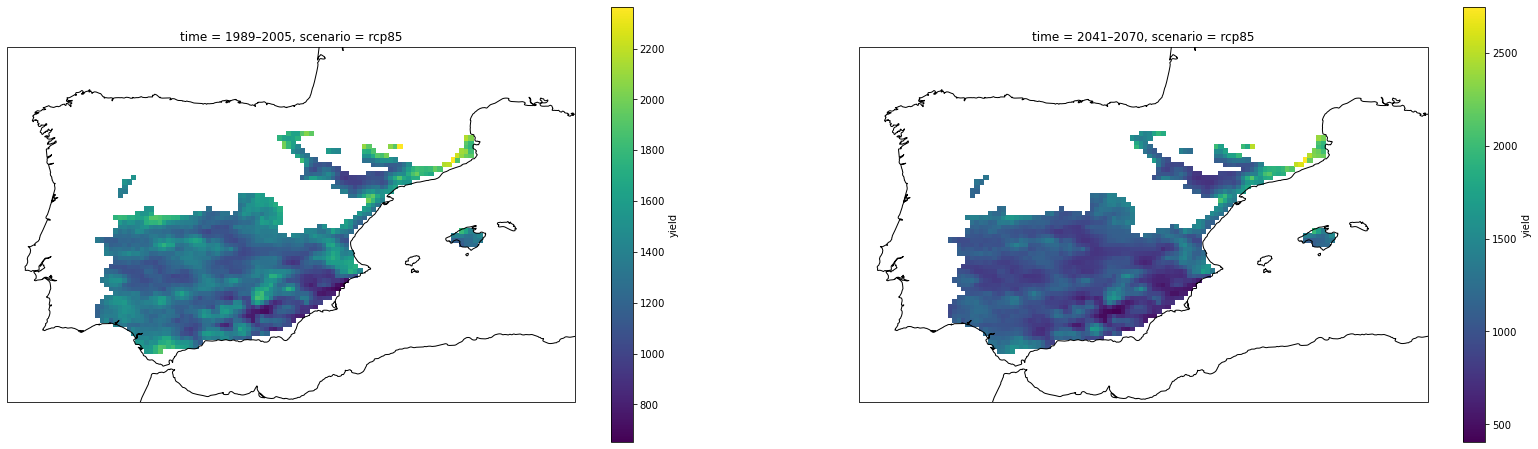

In [169]:
fig = plt.figure(figsize=(28,8))

ax1 = fig.add_subplot(121, projection=ccrs.PlateCarree())
ax2 = fig.add_subplot(122, projection=ccrs.PlateCarree())

ax1.set_global()
ds_clipped['yield'].isel(time=0).sel(scenario='rcp85').plot.pcolormesh(ax=ax1, transform=ccrs.PlateCarree(), x='lon', y='lat', add_colorbar=True)
ax1.coastlines()
ax1.set_ylim([35,45]);
ax1.set_xlim([-10,6]);

ax2.set_global()
ds_clipped['yield'].isel(time=1).sel(scenario='rcp85').plot.pcolormesh(ax=ax2, transform=ccrs.PlateCarree(), x='lon', y='lat', add_colorbar=True)
ax2.coastlines()
ax2.set_ylim([35,45]);
ax2.set_xlim([-10,6]);

**Yield change**

In [185]:
attrs =  ds_clipped.attrs

da = (ds_clipped['yield'].isel(time=1) - ds_clipped['yield'].isel(time=0))/ds_clipped['yield'].isel(time=0) *100
da = da.rename('yield_change_per')
        
ds_change = da.to_dataset().assign_attrs(attrs)

In [186]:
ds_change

<xarray.Dataset>
Dimensions:           (lat: 62, lon: 108, scenario: 2)
Coordinates:
  * lat               (lat) float64 36.06 36.19 36.31 ... 43.44 43.56 43.69
  * lon               (lon) float64 -9.188 -9.062 -8.938 ... 3.938 4.062 4.188
  * scenario          (scenario) <U5 'rcp45' 'rcp85'
    time              <U9 '1989–2005'
Data variables:
    yield_change_per  (scenario, lat, lon) float64 nan nan nan ... nan nan nan
Attributes:
    CDI:          Climate Data Interface version 1.5.0 (http://code.zmaw.de/p...
    Conventions:  CF-1.0
    history:      Wed Nov 24 15:03:28 2021: cdo selvar,yield eval_mean.nc pre...
    CDO:          Climate Data Operators version 1.5.1rc3 (http://code.zmaw.d...

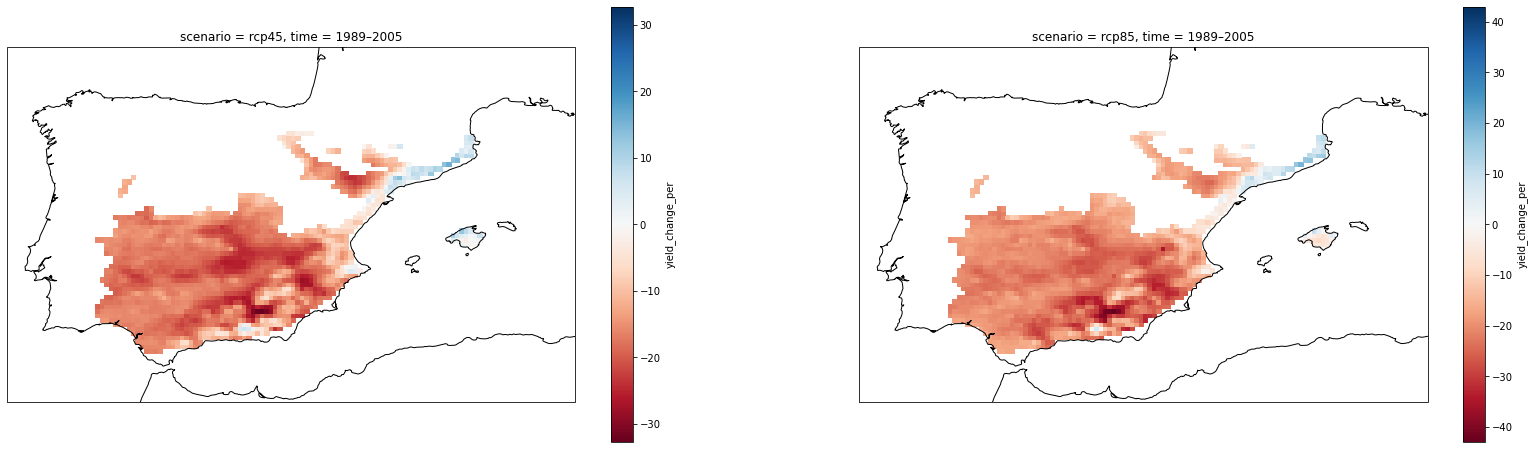

In [187]:
fig = plt.figure(figsize=(28,8))

ax1 = fig.add_subplot(121, projection=ccrs.PlateCarree())
ax2 = fig.add_subplot(122, projection=ccrs.PlateCarree())

ax1.set_global()
ds_change['yield_change_per'].sel(scenario='rcp45').plot.pcolormesh(ax=ax1, cmap='RdBu', transform=ccrs.PlateCarree(), x='lon', y='lat', add_colorbar=True)
ax1.coastlines()
ax1.set_ylim([35,45]);
ax1.set_xlim([-10,6]);

ax2.set_global()
ds_change['yield_change_per'].sel(scenario='rcp85').plot.pcolormesh(ax=ax2, cmap='RdBu', transform=ccrs.PlateCarree(), x='lon', y='lat', add_colorbar=True)
ax2.coastlines()
ax2.set_ylim([35,45]);
ax2.set_xlim([-10,6]);